# S&P 500 Stock Market Index - Companies
**Author:** Nikita Pikulenko

**Intended Goal**: To construct two distinct tables featuring data on S&P 500 companies, and then merge them into a single final table. Store all tables in a newly created database. Finally perform data analysis and create data visualizations. Look at which sectors are leading in terms of average market capitalization and company count. 

**Database Structure**:
* Database Name: sp500_stock_market_index_data
* Tables:
    * companies_spx: Data pulled from website
        * columns: symbol, company_name, sector, market_cap
    * companies_rdf: Data acquired via SPARQL query from DBpedia.
        * columns: symbol, company_name, revenue, net_income, assets, equity, num_of_employees
    * companies_merged: The final table merged with a pandas function taking in an SQL query as input.

**Final Table Specifications**:

* Table Name: companies_merged
* Columns:
    - ticker: The unique stock ticker symbol for each company
    - company_name
    - sector
    - market_cap: the market capitalization of the company
    - revenue
    - net_income
    - assets
    - equity
    - num_of_employees


Navigation Links: <br>
[Database Initialization](#database_init) <br>
[1st Table - Data from Website](#1st_table) <br>
[2nd Table - RDF Part](#rdf_part) <br>
[Merging Tables](#table_merge) <br>
[Data Analysis with Visualization](#data_analysis)

Project Flow:

<img src="bpmn_diagram.jpg" width="1600" height="200" alt="BPMN Diagram of the Project Flow">

<a id="database_init"></a>
# Database Initialization
* Creating a Database called "sp500_stock_market_index_data"
* Activating SQL jupyter extension
* Establishing connection to the database

In [54]:
%reload_ext sql

In [55]:
%sql sqlite:///sp500_stock_market_index_data.db

In [56]:
from sqlalchemy import create_engine

# Establishing connection to our database
conn = create_engine('sqlite:///sp500_stock_market_index_data.db')

<a id="1st_table"></a>
# 1st Table: Pulling Data from a Website
Plan: <br>
1) Import packages
2) Get Initial S&P 500 Data on Companies from the following website: https://www.liberatedstocktrader.com/sp-500-companies
3) Save Table in the DB as "companies_spx"

In [57]:
import pandas as pd
import numpy as np

In [58]:
tables = pd.read_html('https://www.liberatedstocktrader.com/sp-500-companies', header=0)

In [59]:
# pd.read_html() grabs all tables that it sees from a website
# we just take the first table

df_spx = tables[0]

In [60]:
# quick look
df_spx.head()

,Ticker,Description,Sector,Market Capitalization
0,AAPL,Apple Inc.,Electronic Technology,2728017215293
1,MSFT,Microsoft Corporation,Technology Services,2351371643107
2,GOOG,Alphabet Inc.,Technology Services,1611856497958
3,GOOGL,Alphabet Inc.,Technology Services,1610343852181
4,AMZN,"Amazon.com, Inc.",Retail Trade,1366884251763


### Quick Consistency Check
Checking if data types are consistent and there are no missing values and duplicates

In [61]:
df_spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Ticker                 503 non-null    object
 1   Description            503 non-null    object
 2   Sector                 503 non-null    object
 3   Market Capitalization  503 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


<font color='green' size=5>Desired Data Types ✅ </font>

In [62]:
df_spx.isna().sum()

Ticker                   0
Description              0
Sector                   0
Market Capitalization    0
dtype: int64

<font color='green' size=5>No Missing Values ✅ </font>

In [63]:
df_spx.duplicated().sum()

0

<font color='green' size=5>No Duplicates ✅ </font>

### Renaming Columns 
-> to make it less cumbersome to work with

In [64]:
print("Before:", [*df_spx.columns])

Before: ['Ticker', 'Description', 'Sector', 'Market Capitalization']


In [65]:
df_spx.columns = ['symbol', 'company_name', 'sector', 'market_cap']
print("After:", [*df_spx.columns])

After: ['symbol', 'company_name', 'sector', 'market_cap']


### Converting absolute numbers to billions

Before:

In [66]:
df_spx['market_cap'].head(3)

0    2728017215293
1    2351371643107
2    1611856497958
Name: market_cap, dtype: int64

In [67]:
df_spx['market_cap'] = round(df_spx['market_cap'] / 1000000000, 4)

After:

In [68]:
df_spx['market_cap'].head(3)

0    2728.0172
1    2351.3716
2    1611.8565
Name: market_cap, dtype: float64

## Save Table into the Database as "companies_spx"

In [69]:
%sql DROP TABLE IF EXISTS companies_spx

 * sqlite:///sp500_stock_market_index_data.db
Done.


[]

In [70]:
# Saving dataframe as table to our database
df_spx.to_sql('companies_spx', conn, index=False)

503

## Table 1 Result

In [71]:
%sql SELECT * FROM companies_spx LIMIT 15;

 * sqlite:///sp500_stock_market_index_data.db
Done.


symbol,company_name,sector,market_cap
AAPL,Apple Inc.,Electronic Technology,2728.0172
MSFT,Microsoft Corporation,Technology Services,2351.3716
GOOG,Alphabet Inc.,Technology Services,1611.8565
GOOGL,Alphabet Inc.,Technology Services,1610.3439
AMZN,"Amazon.com, Inc.",Retail Trade,1366.8843
NVDA,NVIDIA Corporation,Electronic Technology,1069.4853
BRK.B,Berkshire Hathaway Inc. New,Finance,768.8919
META,"Meta Platforms, Inc.",Technology Services,728.9672
TSLA,"Tesla, Inc.",Consumer Durables,683.9641
LLY,Eli Lilly and Company,Health Technology,518.7233


<a id="rdf_part"></a>
# Next Step: 2nd Table (RDF)

**Additional Data Of Interest**: revenue, netIncome, operatingIncome, assets, equity, numOfEmployees 

### Initializing the Sparql Environment and Constructing the Query

In [72]:
from SPARQLWrapper import SPARQLWrapper, JSON

In [73]:
sparql = SPARQLWrapper('https://dbpedia.org/sparql')

Most of the S&P 500 Companies have following important identifying properties in common: <br>
* dbo:type Public_company
* rdfs:type dbo:Company
* dbp:symbol - the ?symbol they are traded as on the stock market 
* dbo:wikiPageWikiLink - which includes the S&P 500 stock ?exchange as dbr:S&P_500 property 
* rdfs:label - ?company_name

Once successfully identified, additional data can be pulled:
* ?revenue - dbo:revenue
* ?netIncome - dbo:netIncome
* ?assets - dbo:assets
* ?equity - dbo:equity
* ?num_of_employees: dbo:numberOfEmployees

**3 challenges, SOLVED**: 
1) Issue accessing the dbr:S&P_500 property to identify company being part of S&P 500 (because of "&" sign) which is part of dbo:wikiPageWikiLink. We need a workaround.<br><br> **Solution**: check with a regular expression whether dbo:wikiPageWikiLink at any point contains a string 'S&P 500'  -->  (  FILTER(regex(str(?exchange), "S&P_500")) )

2) For some companies, some of the searched properties are not present at all. In this case, we don't want to get rid of corresponding companies completely and mark the values as missing instead, thus making it optinal for some properties to exist. <br><br> **Solution**: use COALESCE function to check if the property exists. If it does keep it, if not write 'nan'. --> f.e COALESCE(?revenue, "nan")) as ?revenue   +   OPTIONAL {?company dbo:revenue ?revenue} .

3) Some properties have a list of multiple values instead of a single value. We just want the first value. <br><br> **Solution**: using SAMPLE function which takes the first value of everything (we use it on top of the output of our COALESCE function, --> f.e  SAMPLE(COALESCE(?revenue, "nan")) as ?revenue, 

Finalized query:

In [74]:
sparql.setQuery("""
PREFIX dbpedia2: <http://dbpedia.org/property/> 
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>

SELECT DISTINCT ?symbol, ?company_name, 
    SAMPLE(COALESCE(?revenue, "nan")) as ?revenue, 
    SAMPLE(COALESCE(?net_income, "nan")) as ?net_income,
    SAMPLE(COALESCE(?assets, "nan")) as ?assets, 
    SAMPLE(COALESCE(?equity, "nan")) as ?equity, 
    SAMPLE(COALESCE(?num_of_employees, "nan")) as ?num_of_employees
WHERE {
   ?company dbo:type dbr:Public_company .
   ?company a dbo:Company .
   ?company dbp:symbol ?symbol .
   ?company rdfs:label ?company_name .
   ?company dbo:wikiPageWikiLink ?exchange .

   OPTIONAL {?company dbo:revenue ?revenue} .
   OPTIONAL {?company dbo:netIncome ?net_income} .
   OPTIONAL {?company dbo:assets ?assets} .
   OPTIONAL {?company dbo:equity ?equity} .
   OPTIONAL {?company dbo:numberOfEmployees ?num_of_employees} .
   
   FILTER(regex(str(?exchange), "S&P_500"))
   FILTER(lang(?symbol) = 'en') 
   FILTER(lang(?company_name) = 'en') 
} LIMIT 1000
""") 

In [75]:
sparql.setReturnFormat(JSON)

Executing the query:

In [76]:
json_rdf = sparql.query().convert()

Taking a look on the output:

In [77]:
json_rdf['results']['bindings'][:1]

[{'symbol': {'type': 'literal', 'xml:lang': 'en', 'value': 'CTLT'},
  'company_name': {'type': 'literal', 'xml:lang': 'en', 'value': 'Catalent'},
  'revenue': {'type': 'typed-literal',
   'datatype': 'http://dbpedia.org/datatype/usDollar',
   'value': '3.998E9'},
  'net_income': {'type': 'typed-literal',
   'datatype': 'http://dbpedia.org/datatype/usDollar',
   'value': '5.85E8'},
  'assets': {'type': 'typed-literal',
   'datatype': 'http://dbpedia.org/datatype/usDollar',
   'value': '9.112E9'},
  'equity': {'type': 'typed-literal',
   'datatype': 'http://dbpedia.org/datatype/usDollar',
   'value': '3.915E9'},
  'num_of_employees': {'type': 'typed-literal',
   'datatype': 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger',
   'value': '14000'}}]

In [78]:
len(json_rdf['results']['bindings'])

443

There are 503 Companies officially registered in the S&P 500. Having 443 of those through a Sparql query is a good ratio (~90%).

#### I want to clean the outputted json dictionary to simplify and prettify it.

In [79]:
# For each key, we only need the value of the nested key named 'value'
# we can use a dictionary comprehension

json_rdf_cleaned = []

for row in json_rdf['results']['bindings']:
    temp_dict = {}
    for key in row.keys():
        temp_dict[key] = row[key]['value']
    json_rdf_cleaned.append(temp_dict)

In [80]:
json_rdf_cleaned[:3]

[{'symbol': 'CTLT',
  'company_name': 'Catalent',
  'revenue': '3.998E9',
  'net_income': '5.85E8',
  'assets': '9.112E9',
  'equity': '3.915E9',
  'num_of_employees': '14000'},
 {'symbol': 'BLK',
  'company_name': 'BlackRock',
  'revenue': '1.917E10',
  'net_income': '5.9E9',
  'assets': '1.5265E11',
  'equity': '3.769E10',
  'num_of_employees': '18400'},
 {'symbol': 'DVN',
  'company_name': 'Devon Energy',
  'revenue': '1.2206E10',
  'net_income': '2.808E9',
  'assets': '2.1025E10',
  'equity': '9.399E9',
  'num_of_employees': '1600'}]

## Creating a DataFrame out of the JSON Dictionary

In [81]:
df_rdf = pd.json_normalize(json_rdf_cleaned)

Table view:

In [82]:
df_rdf.head()

,symbol,company_name,revenue,net_income,assets,equity,num_of_employees
0,CTLT,Catalent,3.998E9,5.85E8,9.112E9,3.915E9,14000
1,BLK,BlackRock,1.917E10,5.9E9,1.5265E11,3.769E10,18400
2,DVN,Devon Energy,1.2206E10,2.808E9,2.1025E10,9.399E9,1600
3,RSG,Republic Services,1.0153E10,9.69E8,2.3434E10,8.488E9,35000
4,ROK,Rockwell Automation,7.76E9,9.19E8,1.076E10,3.02E9,nan


### Checking Missing Values

In [83]:
df_rdf.isna().value_counts()

for col in df_rdf.columns:
    try: 
        print(f"{col}: {df_rdf[col].astype('float').isna().value_counts().values[1]} missing values")
    except:
        continue

revenue: 35 missing values
net_income: 69 missing values
assets: 75 missing values
equity: 86 missing values
num_of_employees: 31 missing values


### Quick Data Processing

Converting the scientific numbers to absolute numbers --> Replacing missing values with 0 (for further division) --> converting to billions (except number of employees) --> rounding to 4 decimals --> replacing 0 with np.nan again

In [84]:
df_rdf['revenue'] = round(df_rdf['revenue'].astype('float').fillna(0) / 1000000000, 4).replace(0, np.nan)
df_rdf['net_income'] = round(df_rdf['net_income'].astype('float').fillna(0) / 1000000000, 4).replace(0, np.nan)
df_rdf['assets'] = round(df_rdf['assets'].astype('float').fillna(0) / 1000000000, 4).replace(0, np.nan)
df_rdf['equity'] = round(df_rdf['equity'].astype('float').fillna(0) / 1000000000, 4).replace(0, np.nan)
df_rdf['num_of_employees'] = df_rdf['num_of_employees'].astype('float').fillna(0).astype('int').replace(0, np.nan)

#### Let's test and find Apple for example:

In [85]:
df_rdf[df_rdf.symbol == 'AAPL']

,symbol,company_name,revenue,net_income,assets,equity,num_of_employees
167,AAPL,Apple Inc.,394.33,99.8,352.76,50.67,164000.0


## Table 2 Result

#### Numbers in Bio. USD. (except num_of_employees)

In [86]:
df_rdf.sort_values(by='revenue', ascending=False).head(10)

,symbol,company_name,revenue,net_income,assets,equity,num_of_employees
230,WMT,Walmart,572.800,13.670,244.860,91.891,2300000.0
97,AMZN,Amazon (company),469.822,33.364,420.549,138.245,NaN
167,AAPL,Apple Inc.,394.330,99.800,352.760,50.670,164000.0
226,CVS,CVS Health,292.110,7.910,232.990,75.380,300000.0
405,UNH,UnitedHealth Group,285.273,17.285,212.206,75.045,380000.0
181,XOM,ExxonMobil,276.692,23.040,338.923,168.577,64000.0
83,BRK.A,Berkshire Hathaway,276.100,89.800,958.800,514.900,372000.0
288,BRK.B,Berkshire Hathaway,276.100,89.800,958.800,514.900,372000.0
248,MCK,McKesson Corporation,263.970,1.290,63.300,1.790,2022.0
130,GOOG,Alphabet Inc.,257.600,76.000,359.300,251.600,186779.0


# Save Table into the Database as "companies_rdf"

At this point connection with database has already been established (conn)

In [87]:
%sql DROP TABLE IF EXISTS companies_rdf

 * sqlite:///sp500_stock_market_index_data.db
Done.


[]

In [88]:
# Saving dataframe as table to our database
df_rdf.to_sql('companies_rdf', conn, index=False)

443

<a id="table_merge"></a>
# Next Step: Merging Tables

Table 1 - companies_spx

In [89]:
%sql SELECT * FROM companies_spx LIMIT 5;

 * sqlite:///sp500_stock_market_index_data.db
Done.


symbol,company_name,sector,market_cap
AAPL,Apple Inc.,Electronic Technology,2728.0172
MSFT,Microsoft Corporation,Technology Services,2351.3716
GOOG,Alphabet Inc.,Technology Services,1611.8565
GOOGL,Alphabet Inc.,Technology Services,1610.3439
AMZN,"Amazon.com, Inc.",Retail Trade,1366.8843


Table 2 - companies_rdf

In [90]:
%sql SELECT * FROM companies_rdf LIMIT 5;

 * sqlite:///sp500_stock_market_index_data.db
Done.


symbol,company_name,revenue,net_income,assets,equity,num_of_employees
CTLT,Catalent,3.998,0.585,9.112,3.915,14000.0
BLK,BlackRock,19.17,5.9,152.65,37.69,18400.0
DVN,Devon Energy,12.206,2.808,21.025,9.399,1600.0
RSG,Republic Services,10.153,0.969,23.434,8.488,35000.0
ROK,Rockwell Automation,7.76,0.919,10.76,3.02,None


#### Building a Query for Merging Tables

In [91]:
%%sql 

SELECT 
    companies_spx.symbol, 
    companies_spx.company_name, 
    sector, 
    market_cap
    revenue,
    net_income,
    assets,
    equity,
    num_of_employees
FROM companies_spx
LEFT JOIN companies_rdf
ON companies_spx.symbol = companies_rdf.symbol
LIMIT 5;

 * sqlite:///sp500_stock_market_index_data.db
Done.


symbol,company_name,sector,revenue,net_income,assets,equity,num_of_employees
AAPL,Apple Inc.,Electronic Technology,2728.0172,99.8,352.76,50.67,164000.0
MSFT,Microsoft Corporation,Technology Services,2351.3716,72.7,364.8,166.5,221000.0
GOOG,Alphabet Inc.,Technology Services,1611.8565,76.0,359.3,251.6,186779.0
GOOGL,Alphabet Inc.,Technology Services,1610.3439,76.0,359.3,251.6,186779.0
AMZN,"Amazon.com, Inc.",Retail Trade,1366.8843,33.364,420.549,138.245,None


To be able to save this query as a new merged table in the database as well as having a new dataframe 'df_merged', I'm using pd.read_sql function and provide it with the previously built query

In [92]:
df_merged = pd.read_sql(sql="""
SELECT 
    companies_spx.symbol, 
    companies_spx.company_name, 
    sector, 
    market_cap,
    revenue,
    net_income,
    assets,
    equity,
    num_of_employees
FROM companies_spx
LEFT JOIN companies_rdf
ON companies_spx.symbol = companies_rdf.symbol
""", 
con=conn)

In [93]:
%sql DROP TABLE IF EXISTS companies_merged

 * sqlite:///sp500_stock_market_index_data.db
Done.


[]

# Save Table into the Database as "companies_merged"

In [94]:
df_merged.to_sql('companies_merged', con=conn)

503

# Final Table

In [95]:
%%sql
SELECT *
FROM companies_merged
ORDER BY market_cap DESC
LIMIT 10;

 * sqlite:///sp500_stock_market_index_data.db
Done.


index,symbol,company_name,sector,market_cap,revenue,net_income,assets,equity,num_of_employees
0,AAPL,Apple Inc.,Electronic Technology,2728.0172,394.33,99.8,352.76,50.67,164000.0
1,MSFT,Microsoft Corporation,Technology Services,2351.3716,198.3,72.7,364.8,166.5,221000.0
2,GOOG,Alphabet Inc.,Technology Services,1611.8565,257.6,76.0,359.3,251.6,186779.0
3,GOOGL,Alphabet Inc.,Technology Services,1610.3439,257.6,76.0,359.3,251.6,186779.0
4,AMZN,"Amazon.com, Inc.",Retail Trade,1366.8843,469.822,33.364,420.549,138.245,None
5,NVDA,NVIDIA Corporation,Electronic Technology,1069.4853,26.91,9.75,44.18,26.61,22473.0
6,BRK.B,Berkshire Hathaway Inc. New,Finance,768.8919,276.1,89.8,958.8,514.9,372000.0
7,META,"Meta Platforms, Inc.",Technology Services,728.9672,117.929,39.37,165.987,124.879,None
8,TSLA,"Tesla, Inc.",Consumer Durables,683.9641,None,5.52,None,None,110000.0
9,LLY,Eli Lilly and Company,Health Technology,518.7233,28.32,5.58,48.81,8.98,2021.0


Some of the companies, as discussed before have some missing values, which is perfectly fine and we can still work with the company data. The data could be filled in manually or through use of other frameworks such as yfinance (Yahoo finance) 

<a id="data_analysis"></a>
# Data Analysis
PS: untoggle the cells to view code by pressing on the 3 dots

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [97]:
# here I'm selecting the relevant data for data visualization
sector_market_caps = df_merged.groupby('sector')['market_cap'].mean().sort_values(ascending=False)
sector_company_counts = df_merged.groupby('sector')['symbol'].count().sort_values(ascending=False)
sector_company_counts_percentages_of_total = round(sector_company_counts / sector_company_counts.sum() * 100, 2)
sector_company_counts_percentages_of_total 

sector
Finance                   18.29
Technology Services        9.94
Electronic Technology      9.74
Health Technology          9.34
Utilities                  6.16
Consumer Non-Durables      6.16
Producer Manufacturing     6.16
Consumer Services          5.77
Process Industries         4.77
Retail Trade               4.57
Energy Minerals            3.18
Transportation             2.98
Commercial Services        2.58
Consumer Durables          2.39
Health Services            2.39
Industrial Services        1.79
Distribution Services      1.79
Non-Energy Minerals        1.39
Communications             0.60
Name: symbol, dtype: float64

# S&P 500 Index Consistuents

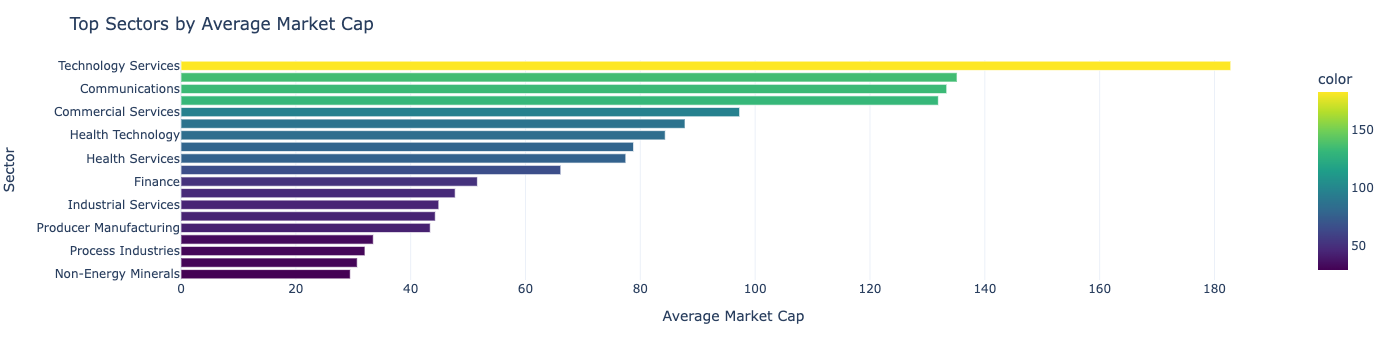

In [98]:
# Plotting a horizontal bar chart of top sectors sorted by their average market capitalization. Horizontal in this case is more appealing.
fig = px.bar(sector_market_caps,
             orientation='h',
             color=sector_market_caps.values,
             color_continuous_scale=px.colors.sequential.Viridis,
             labels={'value':'Average Market Cap', 'index':'Sector'})

# Making the plot prettier and starting with the highest value at the top
fig.update_layout(
    title='Top Sectors by Average Market Cap',
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Average Market Cap',
    yaxis_title='Sector',
    template='plotly_white'
)

fig.show()

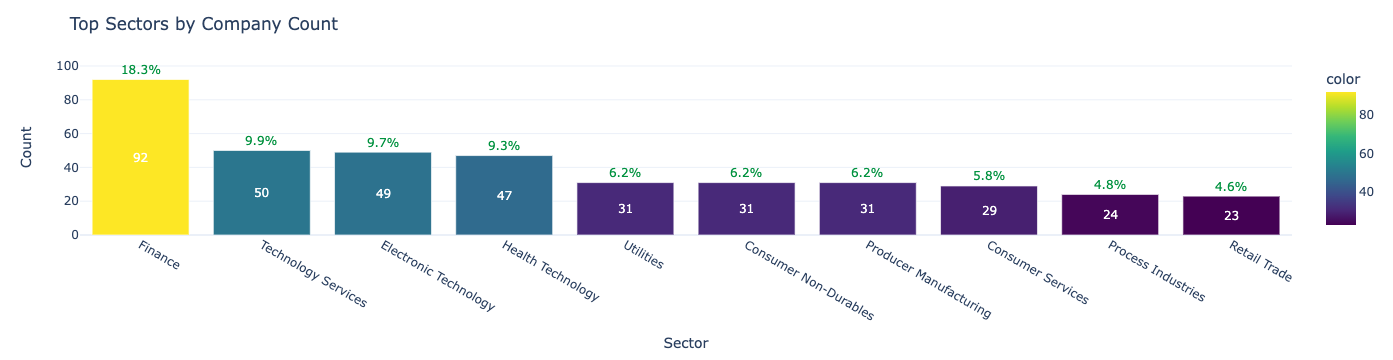

In [99]:
import plotly.express as px
import plotly.graph_objs as go

# Doing same as above, but this time looking at the count of companies for each sector
fig = px.bar(sector_company_counts[:10],
             color=sector_company_counts.values[:10],
             color_continuous_scale=px.colors.sequential.Viridis,
             labels={'value':'Company Count', 'index':'Sector'})

fig.update_layout(
    title='Top Sectors by Company Count',
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Sector',
    yaxis_title='Count',
    template='plotly_white'
)

# Adding absolute and relative annotations of the counts
for i, value in enumerate(sector_company_counts.values[:10]):
    fig.add_annotation(x=sector_company_counts.index[i], y=value,
                       text=f"{sector_company_counts_percentages_of_total[i]:.1f}%",
                       showarrow=False, yshift=10, 
                       font=dict(color="#01923F"))

    fig.add_annotation(x=sector_company_counts.index[i], y=value/2,
                       text=f"{value}",
                       showarrow=False,
                       font=dict(color="white"))

fig.show()

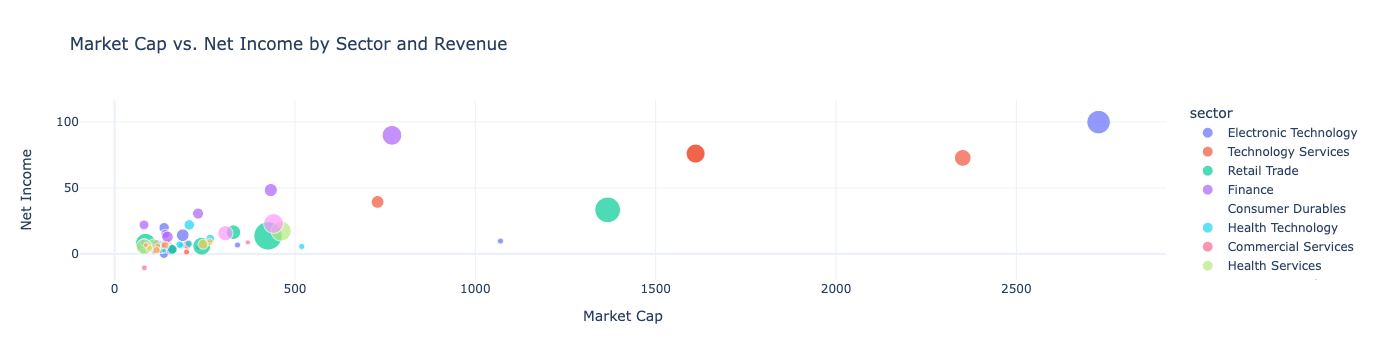

In [100]:
# Replace NaN values in 'equity' with a default value, e.g., the mean or a small number

scatter_marketcap_vs_income = df_merged.fillna(0).sort_values(by='market_cap', ascending=False).head(100)
# Now, creating the scatter plot with Plotly
fig = px.scatter(scatter_marketcap_vs_income,
                 x='market_cap',
                 y='net_income',
                 size='revenue',
                 color='sector',
                 hover_name='company_name',
                 labels={'market_cap': 'Market Cap', 'net_income': 'Net Income', 'equity': 'Equity'},
                 title='Market Cap vs. Net Income by Sector and Revenue',
                 template='plotly_white')

fig.show()

In [101]:
%%sql
SELECT *
FROM companies_merged
WHERE market_cap <= 100 AND net_income < 0

 * sqlite:///sp500_stock_market_index_data.db
Done.


index,symbol,company_name,sector,market_cap,revenue,net_income,assets,equity,num_of_employees
94,SLB,Schlumberger N.V.,Industrial Services,82.4714,23.601,-10.518,42.434,12.489,86000.0
221,BKR,Baker Hughes Company,Industrial Services,35.6004,20.5,-0.219,35.31,16.75,54000.0
225,PCG,Pacific Gas & Electric Co.,Utilities,34.9656,20.64,-0.102,103.33,20.97,26000.0
235,PRU,"Prudential Financial, Inc.",Finance,33.6864,57.033,-0.374,940.722,68.21,41671.0
284,RCL,Royal Caribbean Cruises Ltd.,Consumer Services,25.4124,1.53,-5.26,32.26,5.09,85000.0
335,CCL,Carnival Corporation,Consumer Services,19.5395,1.908,-9.501,53.344,12.144,150000.0
338,LYV,"Live Nation Entertainment, Inc.",Consumer Services,19.4225,1.861,-1.828,10.59,-0.1338,8200.0
445,CZR,"Caesars Entertainment, Inc.",Consumer Services,11.2166,3.5,-1.8,36.4,5.0,54000.0
452,CDAY,Ceridian HCM Holding Inc.,Technology Services,10.8711,1.02,-0.0754,7.17,2.23,7462.0
463,AAL,"American Airlines Group, Inc.",Transportation,9.8266,17.335,-8.45,62.008,-6.867,133700.0


According to our data there are there are 10 companies in the S&P 500 with a market capitalization with less than or equal to 100 billion dollars which have a **negative net income**.<br>
Consumer Services are dominating in the loss race. There is also only 1 company belonging to Technology Services out of all S&P 500 companies.

Which companies with Market Capitalization more or equal to 100 billion have a negative net income ?

In [102]:
%%sql
SELECT *
FROM companies_merged
WHERE market_cap >= 100 AND net_income < 0

 * sqlite:///sp500_stock_market_index_data.db
Done.


index,symbol,company_name,sector,market_cap,revenue,net_income,assets,equity,num_of_employees


It turns out there are no companies in the S&P 500 with a market capitalization with more than or equal to 100 billion dollars which have a **negative net income**.

### Time Series Charts

In [103]:
import yfinance
import datetime as dt

In [104]:
prices_past_30_days = yfinance.Ticker('AAPL').history()[['Close', 'Low', 'High', 'Open']].reset_index()
prices_past_30_days[:10]

,Date,Close,Low,High,Open
0,2023-11-21 00:00:00-05:00,190.639999,189.740005,191.520004,191.410004
1,2023-11-22 00:00:00-05:00,191.309998,190.830002,192.929993,191.490005
2,2023-11-24 00:00:00-05:00,189.970001,189.250000,190.899994,190.869995
3,2023-11-27 00:00:00-05:00,189.789993,188.899994,190.669998,189.919998
4,2023-11-28 00:00:00-05:00,190.399994,189.399994,191.080002,189.779999
5,2023-11-29 00:00:00-05:00,189.369995,188.970001,192.089996,190.899994
6,2023-11-30 00:00:00-05:00,189.949997,188.190002,190.320007,189.839996
7,2023-12-01 00:00:00-05:00,191.240005,189.229996,191.559998,190.330002
8,2023-12-04 00:00:00-05:00,189.429993,187.449997,190.050003,189.979996
9,2023-12-05 00:00:00-05:00,193.419998,190.179993,194.399994,190.210007


In [105]:
prices_past_30_days = pd.concat([prices_past_30_days.Date.dt.date, prices_past_30_days[['Open', 'Low', 'High', 'Close']]], axis=1)

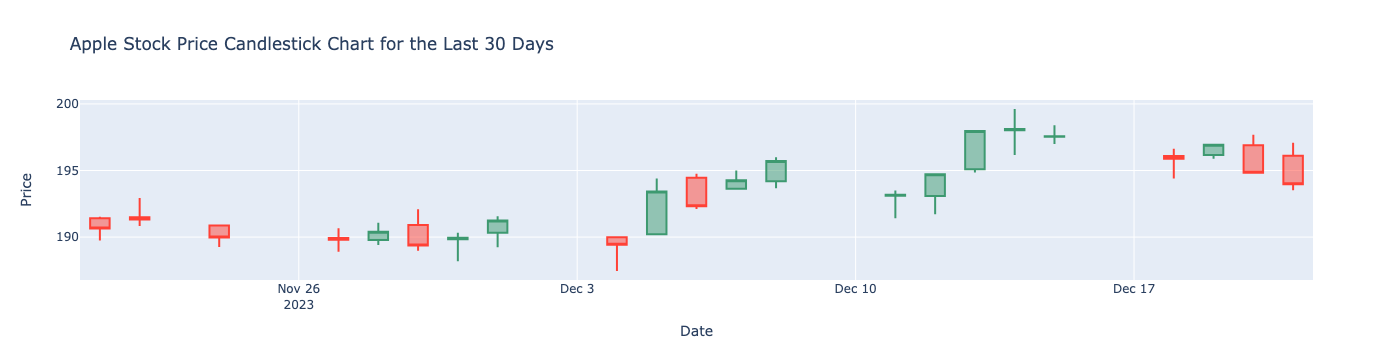

In [106]:
fig = go.Figure(data=[go.Candlestick(x=prices_past_30_days['Date'],
                      open=prices_past_30_days['Open'],
                      high=prices_past_30_days['High'],
                      low=prices_past_30_days['Low'],
                      close=prices_past_30_days['Close']
                                    )])


fig.update_layout(
    title='Apple Stock Price Candlestick Chart for the Last 30 Days',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

fig.show()